In [1]:
# Cell 1 — Imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RSEED = 42
np.random.seed(RSEED)


In [2]:
# Cell 2 — load data
df = pd.read_csv("C:/Users/User/Desktop/Assignments/LAST SEM!!/Machine Learning/house-prices-advanced-regression-techniques/train.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


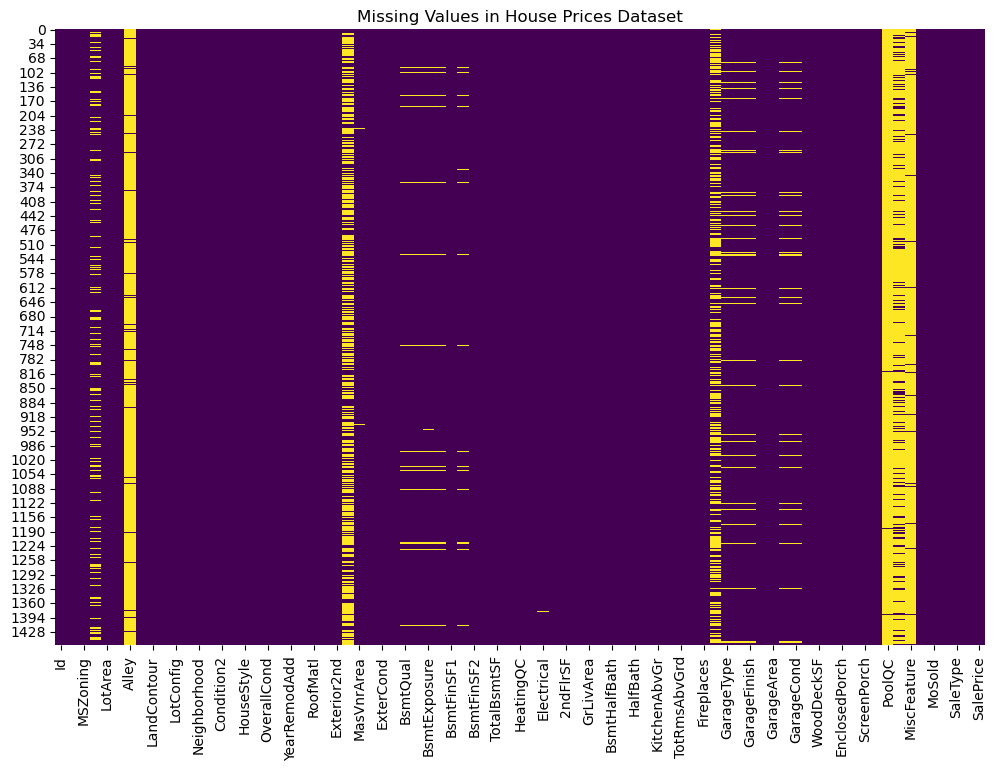

Top 10 features with most missing values:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64


In [3]:
# 🔎 Missing values heatmap (House Prices)
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in House Prices Dataset')
plt.show()

print("Top 10 features with most missing values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))


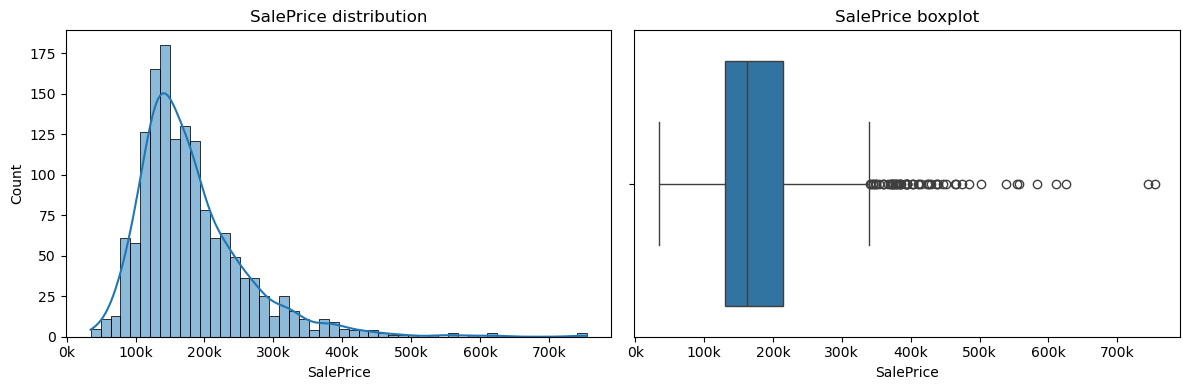

Skewness of SalePrice: 1.8828757597682129


In [4]:
# Cell 3 — Explore target distribution (fixed axis formatting)
import matplotlib.ticker as mtick

plt.figure(figsize=(12,4))

# Histogram
plt.subplot(1,2,1)
sns.histplot(df['SalePrice'], kde=True, bins=50)
plt.title("SalePrice distribution")
plt.xlabel("SalePrice")
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))  # show in 'k'

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=df['SalePrice'])
plt.title("SalePrice boxplot")
plt.xlabel("SalePrice")
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x/1000)}k'))

plt.tight_layout()
plt.show()

print("Skewness of SalePrice:", df['SalePrice'].skew())


In [5]:
# Cell 4 — Transform target to reduce skew (log1p)
df['SalePrice_log'] = np.log1p(df['SalePrice'])   # log(1+x)
y = df['SalePrice_log']                           # target = log-transformed price
X = df.drop(columns=['SalePrice','SalePrice_log','Id'])  # features


In [6]:
# Cell 5 — Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))


Numeric features: 36
Categorical features: 43


In [7]:
# Cell 6 — Example feature engineering
# Add total square footage as a new feature if columns exist
if set(['TotalBsmtSF','1stFlrSF','2ndFlrSF']).issubset(X.columns):
    X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
    num_cols.append('TotalSF')


In [8]:
# Cell 7 — Preprocessing pipelines
# Numeric: fill missing with median + scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical: fill missing with "Missing" + one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot',OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


In [9]:
# Cell 8 — Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=RSEED
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1241, 80)
Test shape: (219, 80)


In [10]:
# Cell 9 — Ridge Regression with GridSearchCV
pipe_ridge = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', Ridge(random_state=RSEED))
])

params = {'model__alpha': [0.1, 1.0, 10.0]}

grid = GridSearchCV(pipe_ridge, params, cv=5,
                    scoring='neg_mean_squared_error',
                    n_jobs=-1)

grid.fit(X_train, y_train)

print("Best Ridge alpha:", grid.best_params_)
pred_ridge = grid.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, pred_ridge))
mae_ridge = mean_absolute_error(y_test, pred_ridge)
r2_ridge = r2_score(y_test, pred_ridge)
print(f"Ridge — RMSE(log): {rmse_ridge:.4f}, MAE(log): {mae_ridge:.4f}, R2: {r2_ridge:.4f}")


Best Ridge alpha: {'model__alpha': 10.0}
Ridge — RMSE(log): 0.1326, MAE(log): 0.0926, R2: 0.9077


In [11]:
# Cell 10 — Random Forest with RandomizedSearchCV
pipe_rf = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', RandomForestRegressor(random_state=RSEED, n_jobs=-1))
])

param_dist = {
    'model__n_estimators': [200, 500],
    'model__max_depth': [8, 12, None],
    'model__min_samples_split': [2, 5, 10]
}

rs_rf = RandomizedSearchCV(pipe_rf, param_dist, n_iter=6, cv=4,
                           scoring='neg_root_mean_squared_error',
                           random_state=RSEED, n_jobs=-1)

rs_rf.fit(X_train, y_train)

print("Best RF params:", rs_rf.best_params_)
pred_rf = rs_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
print("RF test RMSE(log):", rmse_rf)


Best RF params: {'model__n_estimators': 500, 'model__min_samples_split': 2, 'model__max_depth': None}
RF test RMSE(log): 0.14633285087679435


In [12]:
# Cell 11 — XGBoost Regressor
pipe_xgb = Pipeline(steps=[
    ('pre', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror',
                               random_state=RSEED, n_jobs=-1))
])

xgb_params = {
    'model__n_estimators': [200, 500],
    'model__max_depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1]
}

rs_xgb = RandomizedSearchCV(pipe_xgb, xgb_params, n_iter=6, cv=4,
                            scoring='neg_mean_squared_error',
                            random_state=RSEED, n_jobs=-1)

rs_xgb.fit(X_train, y_train)

# ✅ Define prediction variable for test set
pred_xgb = rs_xgb.predict(X_test)

# Optional check on log scale
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
print("XGB test RMSE(log):", rmse_xgb)


XGB test RMSE(log): 0.14057680538891248


In [13]:
# Cell 12 — Evaluate models on original scale (table version)

def eval_on_original(y_true_log, y_pred_log):
    """Return RMSE, MAE, R² on original SalePrice scale."""
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return rmse, mae, r2

# Collect results
results = {
    "Model": ["Ridge", "RandomForest", "XGBoost"],
    "RMSE(orig)": [
        eval_on_original(y_test, pred_ridge)[0],
        eval_on_original(y_test, pred_rf)[0],
        eval_on_original(y_test, pred_xgb)[0]
    ],
    "MAE(orig)": [
        eval_on_original(y_test, pred_ridge)[1],
        eval_on_original(y_test, pred_rf)[1],
        eval_on_original(y_test, pred_xgb)[1]
    ],
    "R2(orig)": [
        eval_on_original(y_test, pred_ridge)[2],
        eval_on_original(y_test, pred_rf)[2],
        eval_on_original(y_test, pred_xgb)[2]
    ]
}

# Show results as table
df_results = pd.DataFrame(results)
display(df_results)


,Model,RMSE(orig),MAE(orig),R2(orig)
0,Ridge,25234.813435,16059.084210,0.921563
1,RandomForest,32509.325604,17442.060587,0.869822
2,XGBoost,30312.248899,16279.896351,0.886823


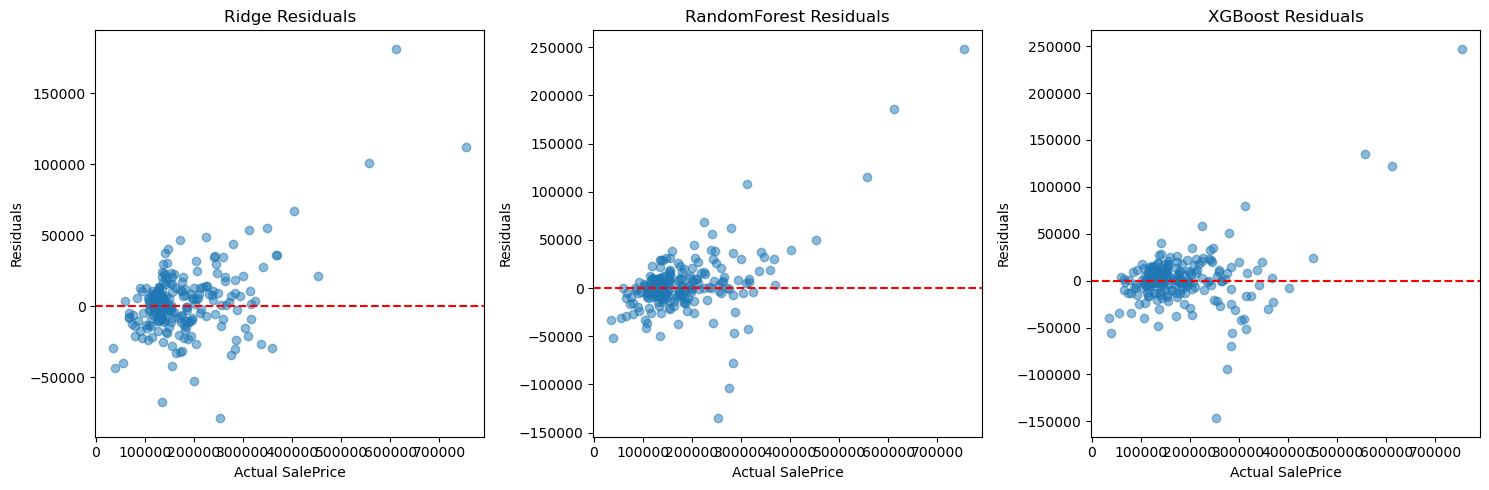

In [14]:
# Cell 13 - Residual Plot
import matplotlib.pyplot as plt

# Dictionary of model predictions
models = {
    "Ridge": pred_ridge,
    "RandomForest": pred_rf,
    "XGBoost": pred_xgb
}

# Plot residuals for each model
plt.figure(figsize=(15, 5))

for i, (name, preds) in enumerate(models.items(), 1):
    plt.subplot(1, 3, i)
    # Convert predictions and y_test back to original SalePrice scale
    y_true = np.expm1(y_test)
    y_pred = np.expm1(preds)
    residuals = y_true - y_pred

    plt.scatter(y_true, residuals, alpha=0.5)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Residuals")
    plt.title(f"{name} Residuals")

plt.tight_layout()
plt.show()

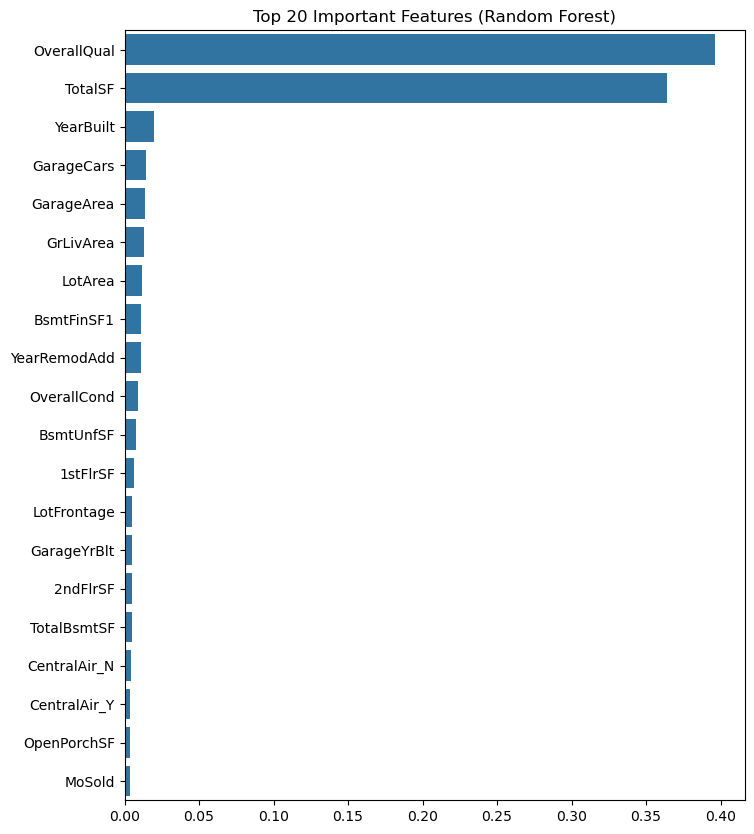

In [15]:
# Cell 14 — Feature importance from Random Forest
# Extract feature names after preprocessing
preprocessor.fit(X_train)
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_feats = ohe.get_feature_names_out(cat_cols)
feat_names = np.array(num_cols + list(cat_feats))

importances = rs_rf.best_estimator_.named_steps['model'].feature_importances_
top_idx = np.argsort(importances)[-20:][::-1]

plt.figure(figsize=(8,10))
sns.barplot(x=importances[top_idx], y=feat_names[top_idx])
plt.title("Top 20 Important Features (Random Forest)")
plt.show()
